In [1]:
import os
import os.path as path
from rdflib import Graph, URIRef, BNode
from rdflib.namespace import RDF, RDFS, OWL
from om.ont import get_namespace, get_n
from cmatcher.owl_utils import load_entities, load_cqas, load_sg, add_depth, to_pyg
# from owl_utils import load_entities, load_cqas, load_sg, add_depth, to_pyg
from termcolor import colored
from tqdm.auto import tqdm
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader as TorchDataLoader
from torch.utils.data import TensorDataset
from torch_geometric.data import Data

from torch_geometric.loader import DataLoader
from cmatcher.cqa_search import build_raw_data, build_graph_dataset, pad_seq
# from cqa_search import build_raw_data, build_graph_dataset, pad_seq
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from multiprocessing_on_dill import Pool
from transformers import AutoTokenizer, BertModel
import torch.utils.checkpoint as checkpoint
import math

import matplotlib.pyplot as plt

/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
paths = {
    'edas.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl',
    'ekaw.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/ekaw.owl',
    'confOf.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/confOf.owl',
    'conference.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/Conference.owl',
    'cmt.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/cmt.owl',
}

cqa_path = '/projets/melodi/gsantoss/data/complex/CQAs'
entities_path = '/projets/melodi/gsantoss/data/complex/entities-cqas'

In [4]:
# paths = {
#     'edas.owl': '/home/guilherme/Documents/kg/conference/edas.owl',
#     'ekaw.owl': '/home/guilherme/Documents/kg/conference/ekaw.owl',
#     'confOf.owl': '/home/guilherme/Documents/kg/conference/confOf.owl',
#     'conference.owl': '/home/guilherme/Documents/kg/conference/Conference.owl',
#     'cmt.owl': '/home/guilherme/Documents/kg/conference/cmt.owl',
# }
# 
# cqa_path = '/home/guilherme/Documents/complex/CQAs'
# entities_path = '/home/guilherme/Documents/complex/entities-cqas'

In [5]:

idata = load_entities(entities_path, paths)
isg = load_sg(entities_path, paths)

cqas = load_cqas(cqa_path)
raw_data = build_raw_data(idata, cqas)


100%|██████████| 101/101 [00:00<00:00, 988.35it/s]


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [7]:
def sg_topg(s, ge, depth=4):
    eg = Graph()
    eg.add((s, RDF.type, OWL.Class))
    add_depth(s, eg, ge, depth)
    cm, pm, fm = to_pyg(s, eg)
    return s, cm, pm, fm


def build_raw_ts(op, data, workers=2):
    ge = Graph().parse(op)

    res = {}
    for k in data:
        tn, ng = data[k]
        res[k] = tn
        for t in ng:
            ge.add(t)

    mc = 0
    mp = 0
    ifd = []
    
    subjects = set(ge.subjects())
    
    with Pool(workers) as p:
        pgs = list(tqdm(p.imap(lambda x: sg_topg(x, ge, depth=4), subjects), total=len(subjects)))
    
    for s, cm, pm, fm in pgs:

        mcc = max(map(len, cm))
        mpc = max(map(len, pm))
        if mcc > mc:
            mc = mcc
        if mpc > mp:
            mp = mpc

        ifd.append((s, cm, pm, fm))

    return ifd, mc, mp, res

ifd, mc, mp, res = build_raw_ts('/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl', isg['edas'], workers=6)

100%|██████████| 524/524 [02:57<00:00,  2.95it/s]


In [8]:

class GNN(MessagePassing):
    def __init__(self):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).

    def forward(self, x, edge_index, edge_features):

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, ef=edge_features)

        return out

    def message(self, x_j, ef):
        return x_j * ef
    

gnn = GNN()

edge_index = torch.LongTensor([[1, 2],
                           [0, 0]])
edge_features = torch.Tensor([[0.5], [1.0]])
x = torch.Tensor([[1], [2], [3]])


data = Data(x=x, edge_index=edge_index, edge_attr=edge_features)
out = gnn(data.x, data.edge_index, data.edge_attr)
print(out)

tensor([[4.],
        [0.],
        [0.]])


In [12]:

class BerdEmb(nn.Module):
    def __init__(self):
        super(BerdEmb, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')


    def forward(self, x):
        mask = x > 0
        out = self.bert(input_ids=x, attention_mask=mask)['last_hidden_state']
        om =  mask.unsqueeze(-1).float()
        mo = out * om
        cf = om.sum(dim=1)
        cf[cf == 0] = 1
        return mo.sum(dim=1) / cf


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.emb = BerdEmb()

    def forward(self, cqa, x, xi, edge_index, edge_attr, edge_attr_i):
        cqa = self.embed_cqa(cqa)
        sbg = self.embed_subg(x, xi, edge_index, edge_attr, edge_attr_i)
        return cqa, sbg
    
    def embed_cqa(self, x):
        return self.emb(x)
    
    def embed_subg(self, x, xi, edge_index, edge_attr, edge_attr_i):
        feats = []
        for f in TorchDataLoader(x, batch_size=2, shuffle=False):
            feats.append(checkpoint.checkpoint(self.emb, f, use_reentrant=False))
        feats = torch.cat(feats, dim=0)
        
        return feats
    
    
gnn = GNN()
model = Model()
# model = nn.DataParallel(model)
model.cuda(0)

Model(
  (emb): BerdEmb(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (Laye

In [10]:
dataset = build_graph_dataset(tokenizer, cqas, idata, raw_data['edas'])


In [13]:
for batch in DataLoader(dataset, batch_size=2):
    print(batch)
    model(batch.cqs.cuda(0), )
    break

GraphDataBatch(rsi=[2], rpi=[2], rni=[2], cqs=[2, 429], cqp=[2, 429], cqn=[2, 429], x_s=[68, 459], x_p=[115, 459], x_n=[149, 459], edge_index_s=[2, 201], edge_index_p=[2, 201], edge_index_n=[2, 406], edge_feat_s=[201, 50], edge_feat_p=[385, 50], edge_feat_n=[406, 50])


In [9]:
def evm(model, dataset, th=0.5):
    model.eval()
    
    res = []
    for batch in DataLoader(dataset, batch_size=2):
        with torch.no_grad():
            cqs, sbgs = model(batch.cqs.cuda(0), batch.x_s.cuda(0), batch.edge_index_s.cuda(0), batch.edge_feat_s.cuda(0))
            isbgs = sbgs[batch.rsi]
            
            
            sim = torch.cosine_similarity(cqs, isbgs) > th
            res.append(sim)
            
    res = torch.cat(res, dim=0)
    
    return (res.sum() / res.size(0)).item()

# dataset = build_graph_dataset(tokenizer, cqas, idata, raw_data['edas'])

# print(evm(model, dataset))

100%|██████████| 546/546 [1:23:12<00:00,  9.14s/it]


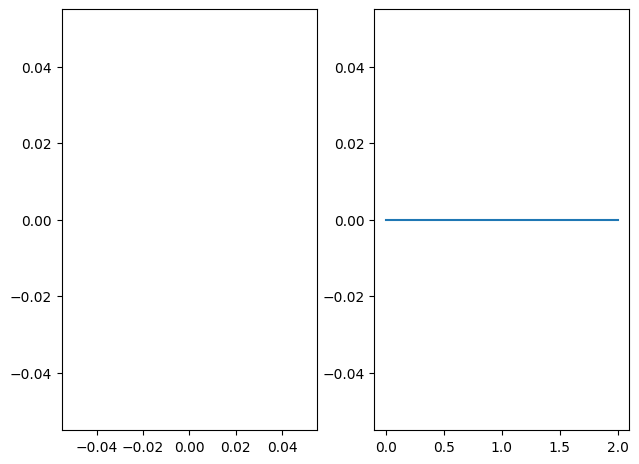

In [11]:


optimizer = optim.Adam(model.parameters(), lr=0.001)

triplet_loss = nn.TripletMarginWithDistanceLoss(margin=0.5, distance_function=lambda x, y: 0.5 - nn.functional.cosine_similarity(x, y))
cossine_loss = nn.CosineSimilarity()


            

lh = []
evh = []
epochs = 3
batch_size = 2
progress = None
for e in range(epochs):
    dataset = build_graph_dataset(tokenizer, cqas, idata, raw_data['edas'])
    if not progress:
        progress = tqdm(total=epochs * math.ceil(len(dataset) / batch_size))
    evh.append(evm(model, dataset))
    model.train()
    el = []
    for batch in DataLoader(dataset, batch_size=batch_size):
        optimizer.zero_grad()
        cqs, sbgs = model(batch.cqs.cuda(0), batch.x_s.cuda(0), batch.edge_index_s.cuda(0), batch.edge_feat_s.cuda(0))
        isbgs = sbgs[batch.rsi]
        
        cqap, sbgp = model(batch.cqp.cuda(0), batch.x_p.cuda(0), batch.edge_index_p.cuda(0), batch.edge_feat_p.cuda(0))
        isbgp = sbgp[batch.rpi]
        
        cqan, sbgn = model(batch.cqn.cuda(0), batch.x_n.cuda(0), batch.edge_index_n.cuda(0), batch.edge_feat_n.cuda(0))
        isbgn = sbgn[batch.rni]
        
        loss1 = triplet_loss(cqs, cqap, cqan)
        loss2 = triplet_loss(isbgs, isbgp, isbgn)
        loss3 = cossine_loss(cqs, isbgs).mean()
        
        loss = loss1 + loss2 + loss3
        el.append(loss.item())
        loss.backward()
        
        optimizer.step()
        progress.update(1)
    
    lh.append(sum(el) / len(el))


progress.close()
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[0].plot(lh)
ax[1].plot(evh)
plt.show()

In [ ]:
class IData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'rsi':
            return self.x_s.size(0)

        if key == 'edge_index_s':
            return self.x_s.size(0)

        return super().__inc__(key, value, *args, **kwargs)



def embed_subg(model, ifd, tokenizer, mc, mp):
    model.eval()
    ts = []
    graph_data = []
    for s, cm, pm, fm in tqdm(ifd):
        e1id = tokenizer(cm, return_tensors='pt', padding=True)['input_ids']
        pd1 = pad_seq(e1id, mc)
        pd1 = torch.cat([torch.zeros((1, mc)), pd1], dim=0)

        e1pid = tokenizer(pm, return_tensors='pt', padding=True)['input_ids']
        pd3 = pad_seq(e1pid, mp)

        edge1 = torch.LongTensor(fm)

        ts.append(s)
        graph_data.append(IData(rsi=torch.LongTensor([0]), x_s=pd1.long(), edge_index_s=edge1, edge_feat_s=pd3))

    fe = []
    for batch in tqdm(DataLoader(graph_data, batch_size=2, shuffle=False)):
        with torch.no_grad():
            out = model.embed_subg(batch.x_s.cuda(0), batch.edge_index_s, batch.edge_feat_s)
            fe.append(out[batch.rsi])

    fe = torch.cat(fe, dim=0)

    return ts, fe

model = model.module.cuda(0)
root_entities, graph_embeddings = embed_subg(model, ifd, tokenizer, mc, mp)

In [ ]:
def embed_cqas(model, data, tokenizer):
    model.eval()
    cq = []
    cqi = []
    for k in data:
        cq.append(k)
        cqi.append(data[k])
    
    cqid = tokenizer(cqi, return_tensors='pt', padding=True)['input_ids']
    
    cqeb = []
    
    for c in DataLoader(cqid, batch_size=2, shuffle=False):
        with torch.no_grad():
            out = model.embed_cqa(c.cuda(0))            
            cqeb.append(out)
        
    cqeb = torch.cat(cqeb, dim=0)
    return cq, cqeb


cq, cqeb = embed_cqas(model, cqas['edas'], tokenizer)

In [ ]:
def eval_metrics(cqa_list, cqa_embeddings, fe, ts, res, th=0.8):
    metrics = []

    for cqa_name, e in zip(cqa_list, cqa_embeddings):
        sim = torch.cosine_similarity(e.unsqueeze(0), fe, dim=1)
        resid = torch.where(sim > th)[0]
        rs = set()
        for r in resid:
            rs.add(ts[r.item()])
        metrics.append((1 if res[cqa_name] in rs else 0, len(rs)))

    rc = sum([m[0] for m in metrics]) / len(metrics)
    avgp = sum([1 / m[1] if m[1] > 0 else 0 for m in metrics]) / len(metrics)
    fm = 2 * rc * avgp / (rc + avgp) if rc + avgp > 0 else 0
    return rc, avgp, fm

avgp, rc, fm = eval_metrics(cq, cqeb, graph_embeddings, root_entities, res, th=0.0)
print(f'avgp: {avgp:.2f}, rec: {rc:.2f}, afm: {fm:.2f}')